In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

In [2]:
pd.set_option('display.max_rows',10)

Nomenklatur:
- `PassengerId` type should be integers
- `Survived` Survived or Not
- `Pclass` Class of Travel (1st paling tinggi dan mahal)
- `Name` Name of Passenger
- `Sex` Gender
- `Age`
- `SibSp` Number of Sibling/Spouse aboard
- `Parch` Number of Parent/Child aboard
- `Ticket`
- `Fare`
- `Cabin`
- `Embarked` The port in which a passenger has embarked. C - Cherbourg, S - Southampton, Q = Queenstown

In [3]:
df = pd.read_csv("data/titanic-train.csv", index_col="PassengerId")
df.tail()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [4]:
var_to_drop = ["Name", "Ticket"]
df.drop(var_to_drop, axis=1, inplace=True)

# Quick EDA

In [5]:
df.isna().sum()
# df.isna().sum()/len(df)

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Ternyata fitur `Age` dan `Cabin` memiliki data yang hilang sampai 20% dan 77%
Kita coba berpikir simple dulu dan buang saja fitur ini dibanding _impute_

Berikut visualisasi data yang hilang

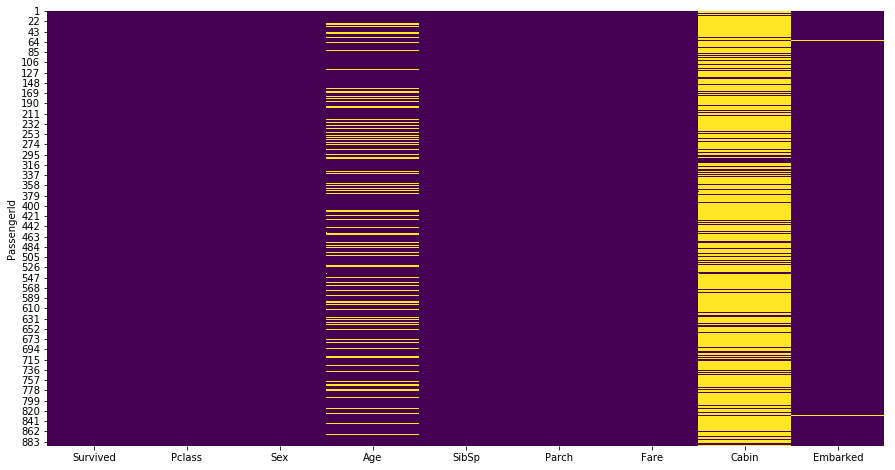

In [6]:
plt.figure(figsize=(15,8))
sns.heatmap(df.isna(), cbar=False, cmap='viridis');

In [7]:
df.drop(["Age", "Cabin"], axis=1, inplace=True)

Untuk variable embarked, kita impute karena hanya 2 saja yang kosong. Karena dia kategorikal, mending pakai modus dari datanya

In [8]:
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [9]:
df.fillna({"Embarked": "S"}, inplace=True)

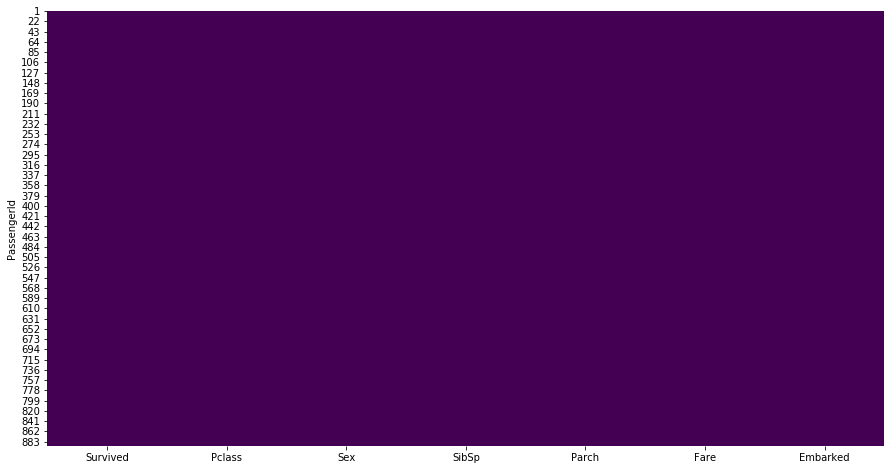

In [10]:
plt.figure(figsize=(15,8))
sns.heatmap(df.isna(), cbar=False, cmap="viridis");

# Data Preparation

In [11]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [12]:
X = df.iloc[:, 1:]
y = df.Survived

X = pd.get_dummies(X, columns=["Pclass", "Sex", "Embarked"])

In [13]:
X

,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
1,1,0,7.2500,0,0,1,0,1,0,0,1
2,1,0,71.2833,1,0,0,1,0,1,0,0
3,0,0,7.9250,0,0,1,1,0,0,0,1
4,1,0,53.1000,1,0,0,1,0,0,0,1
5,0,0,8.0500,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
887,0,0,13.0000,0,1,0,0,1,0,0,1
888,0,0,30.0000,1,0,0,1,0,0,0,1
889,1,2,23.4500,0,0,1,1,0,0,0,1


# Training

In [14]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

# Performance Check

In [15]:
knn.score(X, y)

0.8933782267115601

# Concept 1: Dataset Splitting

Machine Learning is a study to provide a machine ability to learn without explicitly program
- Supervised
- Unsupervised
- Reinforcement

Purpose of supervised learning is to create a model, that are general enough, that it can predict beyond the trained data
Kalau pakai seluruh data untuk di train, ya wajar saja kalau model nya bagus, karena itu semua di train

Bagaimana cara kita cek generality ? Caranya adalah, jangan pakai semua data untuk training, tetapi sisihkan sebagian data sebagai test set

Kalau memang model kita mampu memprediksi test set dengan baik, barulah modelnya kita asumsikan performanya baik dan general enough

In [16]:
X = df.iloc[:, 1:]
y = df.Survived

X = pd.get_dummies(X, columns=["Pclass", "Sex", "Embarked"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 11), (179, 11), (712,), (179,))

In [17]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print(knn.score(X_train, y_train), knn.score(X_test, y_test))

0.8651685393258427 0.6759776536312849


Terbukti kan, yang akurasi tinggi di train itu wajar, tapi ternyata ketika prediksi data di luar itu, score nya menjadi jauh lebih rendah

Kondisi ini kita sebut sebagai overfit. Kita terlalu memaksakan score kita tinggi di train, tetapi ternyata itu tidak berdampak baik untuk data di luar train

Sekarang coba run lagi code yang sama

In [18]:
X = df.iloc[:, 1:]
y = df.Survived

X = pd.get_dummies(X, columns=["Pclass", "Sex", "Embarked"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print(knn.score(X_train, y_train), knn.score(X_test, y_test))

0.8960674157303371 0.7430167597765364


ternyata setiap kali kita run hasilnya berubah" karena train-test split yang acak<br>
kalau begitu jadi ada faktor _luck_ oleh train-test splitting donk ?

# Concept 2: K-fold Splitting

Untuk mengurangi _luck_ dari splitting, kita akan melakukan splitting secara bergantian terhadap seluruh data sebanyak K kali, lalu merata-ratakan semua score nya sehingga kita memperoleh rata-rata score dari 5 split berbeda yang mencakup seluruh data 

In [19]:
X = df.iloc[:, 1:]
y = df.Survived

X = pd.get_dummies(X, columns=["Pclass", "Sex", "Embarked"])

knn = KNeighborsClassifier(n_neighbors=1)
cross_val_score(knn, X, y, cv=5)
# cross_val_score(knn, X, y, cv=5).mean()

array([0.62569832, 0.6424581 , 0.83146067, 0.76404494, 0.74576271])

In [20]:
X.shape

(891, 11)

In [21]:
X = df.iloc[:, 1:]
y = df.Survived

X = pd.get_dummies(X, columns=["Pclass", "Sex", "Embarked"])

knn = KNeighborsClassifier(n_neighbors=1)
cross_val_score(knn, X, y, cv=ShuffleSplit(n_splits=10, train_size=0.8, test_size=0.2, random_state=42)).mean()

0.7430167597765363

score sudah lebih stabil, tetapi masih bisa kita paksakan berdasarkan _luck_<br>
nanti masih ada solusi untuk menangani itu, tapi untuk sekarang paling tidak kita sudah berhasil mengurangi faktor _luck_

# Concept 3: Feature Scaling

Karena KNN memanfaatkan informasi distance untuk membuat modelnya, maka distance antarfitur juga perlu kita buat menjadi fair satu sama lain. Hindari perbedaan skala dalam fitur seperti diskon yang skalanya 0.-an, nilai ujian yang skalanya 100, dan uang yang skalanya bisa jutaan.<br>
Salah satu cara untuk meng-handle ini adalah menggunakan feature scaling seperti MinMaxScaler, StandardScaler, dan RobustScaler

In [22]:
X = df.iloc[:, 1:]
y = df.Survived

X = pd.get_dummies(X, columns=["Pclass", "Sex", "Embarked"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 11), (179, 11), (712,), (179,))

In [23]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print(knn.score(X_train, y_train), knn.score(X_test, y_test))

0.9115168539325843 0.7094972067039106


Tidak ada pengaruh terhadap overfit, apakah kita bisa mengurangi overfit tersebut ?<br>
Jawabannya ada di parameter tuning

# Concept 4: Parameter Tuning

In [25]:
X = df.iloc[:, 1:]
y = df.Survived
X = pd.get_dummies(X, columns=["Pclass", "Sex", "Embarked"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

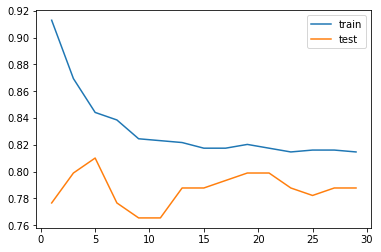

In [26]:
train_score = []
test_score = []
for i in range(1, 30, 2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    train_score.append(knn.score(X_train, y_train))
    test_score.append(knn.score(X_test, y_test))
plt.plot(range(1, 30, 2), train_score, label="train")
plt.plot(range(1, 30, 2), test_score, label="test")
plt.legend()

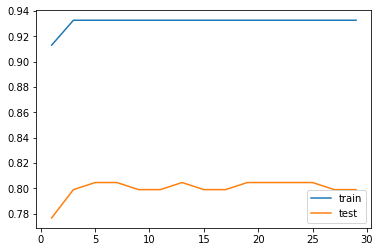

In [27]:
train_score = []
test_score = []
for i in range(1, 30, 2):
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn.fit(X_train, y_train)
    train_score.append(knn.score(X_train, y_train))
    test_score.append(knn.score(X_test, y_test))
plt.plot(range(1, 30, 2), train_score, label="train")
plt.plot(range(1, 30, 2), test_score, label="test")
plt.legend()

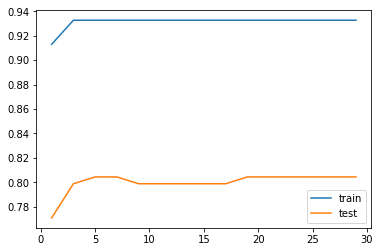

In [28]:
train_score = []
test_score = []
for i in range(1, 30, 2):
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance', p=1)
    knn.fit(X_train, y_train)
    train_score.append(knn.score(X_train, y_train))
    test_score.append(knn.score(X_test, y_test))
plt.plot(range(1, 30, 2), train_score, label="train")
plt.plot(range(1, 30, 2), test_score, label="test")
plt.legend()

Perhatikan bahwa mengubah weight menjadi distance tidak begitu pengaruh, hal ini karena sudah kita scaling di awal<br>
Dari sini, kita sudah bertemu dengan alternatif, apakah menggunakan fitur yang di scale, atau menggunakan KNN tetapi di weight berdasarkan jarak<br>
Let's see apa yang terjadi apabila kita menggunakan KNN yang weighted by distance, tanpa scaling

In [29]:
X = df.iloc[:, 1:]
y = df.Survived
X = pd.get_dummies(X, columns=["Pclass", "Sex", "Embarked"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

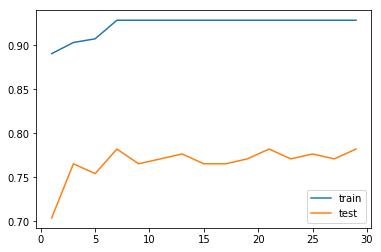

In [30]:
train_score = []
test_score = []
for i in range(1, 30, 2):
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn.fit(X_train, y_train)
    train_score.append(knn.score(X_train, y_train))
    test_score.append(knn.score(X_test, y_test))
plt.plot(range(1, 30, 2), train_score, label="train")
plt.plot(range(1, 30, 2), test_score, label="test")
plt.legend()

# Concept 5: GridSearchCV and Pipeline

### Train-Val-Test Splitting

Supaya hampir tidak ada faktor _luck_ oleh karena splitting, kita sisihkan data dari awal sebagai hold-out data (data yang tidak pernah tersentuh) yang sekarang kita sebut `Test Set`

Kemudian sisanya akan kita lakukan KFold splitting yang sekarang kita sebut sebagai `Train set` dan `Validation Set`<br>
Kfold Splitting tersebut berganti nama menjadi K-fold Cross Validation

In [31]:
X = df.iloc[:, 1:]
y = df.Survived

X = pd.get_dummies(X, columns=["Pclass", "Sex", "Embarked"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 11), (179, 11), (712,), (179,))

gunakan juga random_state untuk shuffle yang reproducible

### Scikit-learn Pipeline

In [32]:
pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("knn", KNeighborsClassifier())
])

### GridsearchCV

Barulah kita menggunakan GridSearch pada Train dan Validation set sebagai metode untuk melakukan tuning<br>
Setelah tuning, barulah kita uji ke data yang benar-benar belum kita sentuh, yaitu `Test Set`

In [33]:
parameter = {
    "knn__n_neighbors": np.arange(1, 31, 2),
    "knn__weights": ['uniform', 'distance'],
    "knn__p": [1, 2]
}
knn = GridSearchCV(pipeline, param_grid=parameter, cv=5, n_jobs=-1)
knn.fit(X_train, y_train)
knn.best_params_

{'knn__n_neighbors': 23, 'knn__p': 1, 'knn__weights': 'uniform'}

In [34]:
knn.best_score_

0.8019662921348315

In [35]:
knn.score(X_test, y_test)

0.7932960893854749

# Summary of Scikit-Learn Workflow

In [37]:
# Load Data
df = pd.read_csv("data/titanic-train.csv", index_col="PassengerId")

# Data Preprocessing
var_to_drop = ["Name", "Ticket"]
df.drop(var_to_drop, axis=1, inplace=True)
df.drop(["Age", "Cabin"], axis=1, inplace=True)
df.fillna({"Embarked": "S"}, inplace=True)

# Data Preparation
X = df.iloc[:, 1:]
y = df.Survived
X = pd.get_dummies(X, columns=["Pclass", "Sex", "Embarked"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training
pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("knn", KNeighborsClassifier())
])

parameter = {
    "knn__n_neighbors": np.arange(1, 31, 2),
    "knn__weights": ['uniform', 'distance'],
    "knn__p": [1, 2]
}
knn = GridSearchCV(pipeline, param_grid=parameter, cv=5, n_jobs=-1)
knn.fit(X_train, y_train)

# Evaluation
print(knn.best_params_)
print(knn.best_score_)
print(knn.score(X_test, y_test))

{'knn__n_neighbors': 23, 'knn__p': 1, 'knn__weights': 'uniform'}
0.8019662921348315
0.7932960893854749


# Prediction

In [38]:
X.iloc[:1]

,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,
1,1,0,7.25,0,0,1,0,1,0,0,1


In [39]:
X_pred = np.array([2, 2, 5, 0, 0, 1, 0, 1, 0, 0, 1]).reshape(1, -1)
knn.predict(X_pred)

array([0])

In [40]:
X_pred = np.array([2, 2, 10, 1, 0, 0, 0, 1, 0, 0, 1]).reshape(1, -1)
knn.predict(X_pred)

array([0])

In [41]:
X_pred = np.array([0, 0, 80, 1, 0, 0, 1, 0, 0, 0, 1]).reshape(1, -1)
knn.predict(X_pred)

array([1])

# Save my model

Everything is object in python, and object can be binarized

In [42]:
import pickle

In [ ]:
pickle.dump(knn, open("knn_titanic.pkl", "wb")) # wb = write-binary

# End of Notes

Today is all about scikit-learn workflow and some important concepts in Machine Learning<br>
Next we are going to focus on Exploratory Data Analysis and Data Wrangling by combining pandas into scikit-learn<br>
Hal yang perlu diperhatikan adalah di workflow kali ini terjadi data leakage